In [1]:
from datascience import *
from prob140 import *
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from scipy import stats
from scipy import special
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression


## Due date: Tuesday 02/04 at 11.59 pm ##

# Lab 2: Statistics: Maximum likelihood estimation and Least squares regression#

In this lab we are going to use Python to review some statistics concepts studied in class:
- Maximum likelihood estimation
- Least squares regression

## Part 1: Maximum likelihood estimation ##
Likelihood functions can be complicated and MLEs can't always be found analytically. This exercise is about an example where the maximization has to be done numerically. 

For $n > 1$ let $X_1, X_2, \ldots, X_n$ be i.i.d., each with the gamma $(r, \lambda)$ distribution. 
Therefore, with the following density:
$$
f(x)=\frac{\lambda^r}{\Gamma(r)} x^{r-1} e^{-\lambda x}
$$

Suppose that we are all-knowing, and suppose we know that the true value of $r$ is 3 and the true value of $\lambda$ is 0.25. Run the cell below to create a sample of size $n = 625$. We are going to give this sample to some data scientists and ask them to use the maximum likelihood method to estimate $r$ and $\lambda$. 

In [2]:
true_r = 3
true_lam = 0.25

n = 625

original_sample = stats.gamma.rvs(true_r, scale=1/true_lam, size=n)
original_tbl = Table().with_column('Original Sample', original_sample)

Run the cell below to see the distribution of the sample.

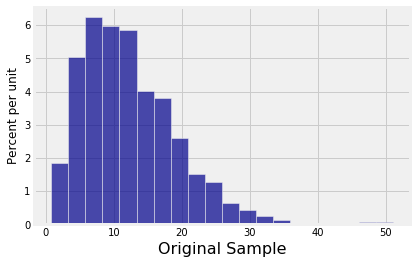

In [3]:
original_tbl.hist(bins=20)

Let $\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i$. What is $E(\bar{X}_n)$?

#student

In the cell below, find the observed value of $\bar{X}_n$ in the sample created above.

In [4]:
#student
#expected value is the average, which will be r/lamda, which is 12
sumx = 0
for i in original_sample:
    sumx = sumx+i
sumx/n
# value of Xn from above sample is as shown in the output

12.252489165269479

### 1.1: MLE of $\lambda$ ###
Write the log likelihood function $L(r, \lambda)$ given an i.i.d. gamma $(r, \lambda)$ sample $X_1, X_2, \ldots, X_n$. For fixed $r$, find the value of $\lambda$ that maximizes this log likelihood function. Your answer should be in terms of $r$ and the sample.

In [ ]:
#student: written part

### 1.2: MLE of $r$ ###
Now write the equation that has to be solved to find the maximizing value of $r$. The equation should just involve $r$ and the sample. Don't try to solve the equation

#student: written part


The equation doesn't have a closed-form analytical solution. The data scientists are going to have to see if they can maximize the log likelihood function numerically. The answers might be approximations, but good optimization programs work very well with smooth functions. 

Help the data scientists by defining the function `log_likelihood` in the cell below. It takes $r$, $\lambda$ and the data as arguments and should return the log likelihood based on $r$, $\lambda$, and the values of the data.

Helpful code:
- `np.log(x)` for $\log(x)$; `x` can be an array
- `special.gamma(x)` for $\Gamma(x)$ where `x` is a positive number; the `special` module of `SciPy` has been imported for you

You can use `n` in place of 625 as `n = 625` was assigned earlier.

In [16]:
#student
#your solution to 6a

def log_likelihood(r, lam, data):
    sumx = 0
    suml = 0
    for i in data:
        sumx = sumx + i
        suml = suml + np.log(i)
    sample_sum = sumx
    sum_of_logs = suml
    temp = len(data)*r*np.log(lam)-len(data)*np.log(special.gamma(r))+(r-1)*sum_of_logs-lam*sample_sum
    return temp

Most numerical optimization systems include a minimizing function because minimizing distances is a common use. The data scientists are going to use the function `minimize` from the `datascience` library. It is a version of the `minimize` function in the `optimize` module of `SciPy`. 

The argument of `minimize` is the name of the function being minimized. This function must only take numerical arguments (more than one is fine) and return a numerical output. 

`minimize` returns the minimizing argument (or arguments) of the specified function.

The example below shows how to use `minimize` to find the values of $a$ and $b$ that minimize $f(a, b) = a^2 + b^2 + 2$. The math answer is $a = 0$ and $b = 0$.

In [17]:
def f(a, b):
    return a**2 + b**2 + 2

minimize(f)

array([3.16392934e-11, 3.16392934e-11])

Maximizing a function is the same as minimizing the negative of that function. In the cell below, define the function that has to be specified as the argument to `minimize` in order to find the maximum likelihood estimates of $r$ and $\lambda$. Remember that the function should only take $r$ and $\lambda$ as its arguments.

In [18]:
#student
#your solution to 6b

def function_to_minimize(r, lam):
    return -log_likelihood(r, lam, original_sample)

Minimizing complicated functions isn't easy and the default numerical method used by `minimize` doesn't do well with the gamma log likelihood function. But `minimize` takes an optional argument that specifies the numerical method that should be used for optimization. We have specified the option `method = 'Nelder-Mead'` when you use `minimize` below. This specifies a simplex algorithm and works just fine. You don't have to worry about this detail but you're welcome to look up simplex algorithms if you are interested.

Run the cell below. If you have defined your functions correctly above, you are likely to see pretty good estimates of the true values of $r$ and $\lambda$ specified at the start of the exercise.

In [19]:
minimize(function_to_minimize, method = 'Nelder-Mead')

array([3.03817035, 0.24796312])

These are the data scientists' estimates $\hat{r}$ and $\hat{\lambda}$ based on their sample. 

## Part 2: Least squares regression ##

A 2013 study in the International Journal of Exercise Science studied collegiate shot put athletes and examined the relation between strength and shot put distance. The population consists of 28 female collegiate athletes. Strength was measured by the the biggest amount (in kilograms) that the athlete lifted in the "1RM power clean" in the pre-season. The distance (in meters) was the athlete's personal best.

In [25]:
shotput = Table.read_table('shotput.csv')
shotput

Weight Lifted,Shotput Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


Let's take a look at the scatterplot of Distance versus Weight.

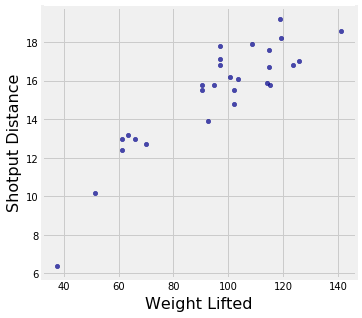

In [28]:
#student
shotput.scatter("Weight Lifted", "Shotput Distance")

### 2.1: Fitting least squares to the data ###

We want to fit to this data least squares regression to find the best straight line to make our prediction.
We can use the scikit-learn implementation of Linear Regression.
In the following X is the matrix of explanatory variables and y is the vector of the response.

In [29]:
X=shotput['Weight Lifted']
y=shotput['Shotput Distance']
lr = LinearRegression()
lr.fit(np.reshape(X,(-1,1)), y) #X needs to be in matrix form
q=lr.intercept_ #intercept
m=lr.coef_[0] #slope
q,m  

(5.959629098373954, 0.09834382159781996)

We want now to plot over the scatterplot the regression line. To do so, first of all we need to find the predicted value $\hat{y}=mx+q$. We can use lr.predict(X) where X is the matrix of values of the explanatory variables for which we want to find the predicted values.

In [32]:
#student
predicted=lr.predict(np.reshape(X,(28,1)))
predicted

array([ 9.64752241, 11.02433591, 11.98810536, 11.98810536, 12.21429615,
       12.46015571, 12.84369661, 15.07610136, 14.85974495, 14.85974495,
       15.28262339, 15.49897979, 15.49897979, 15.49897979, 15.9906989 ,
       15.9906989 , 16.14804902, 15.83334879, 16.62009936, 17.17082476,
       17.29867173, 17.2593342 , 17.23966544, 18.11492545, 18.33128186,
       17.67237825, 17.65270949, 19.83594233])

Augment now the table shotput with a column called 'Predicted  Shotput Distance' that contains the predicted distance under the linear model. 

In [38]:
#student
shotput['Predicted Shotput Distance'] = predicted
z = shotput['Predicted Shotput Distance']

Add to the scatter plot of before the predicted value just computed.

Text(0, 0.5, 'Shotput Distance')

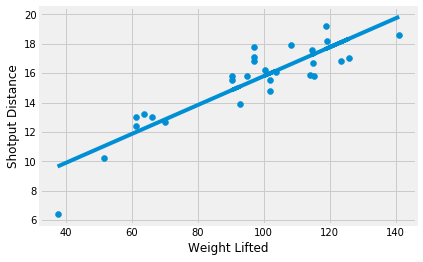

In [42]:
#student
plt.scatter(X,y)
plt.plot(X,z)
plt.xlabel('Weight Lifted')
plt.ylabel('Shotput Distance')

### 2.2: Least squares line minimize the MSE ###

We verify now that the intercept and the slope founded by the routine of scikit-learn are the one that minimize the Mean Squared error.
Define a function called shotput_linear_mse that takes an arbirtary slope and intercept as arguments and return the corresponding mse. 

In [43]:
#student
def shotput_linear_mse(any_slope, any_intercept):
    x=shotput['Weight Lifted']
    y=shotput['Shotput Distance']
    fitted = any_slope * x + any_intercept
    mse = np.mean((y - fitted) ** 2)
    return mse

Use minimize just as before to find the constants that minimize the mean squared error.

In [63]:
#student
[m1,q1] = minimize(shotput_linear_mse, method = 'Nelder-Mead')
m1,q1

(0.09834412178416452, 5.959609723457708)

### 2.3: Prediction of X given Y ###

Use now the Python routine to find the least squares line for prediction of Weight Lifted given Shotput distance.

In [64]:
#student
def shotput_linear_mse_y(any_slope, any_intercept):
    x=shotput['Weight Lifted']
    y=shotput['Shotput Distance']
    fitted = any_slope * y + any_intercept
    mse = np.mean((x - fitted) ** 2)
    return mse
[m2,q2] = minimize(shotput_linear_mse_y, method = 'Nelder-Mead')
m2,q2

(8.108641538351494, -28.975182579295026)

Considering the two models y=q+mx and x=q'+m'y, do the estimates of the two models agree? Why?

#student:

Text(0, 0.5, 'Shotput Distance')

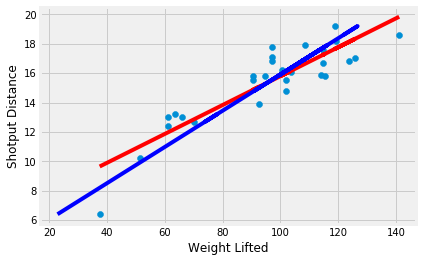

In [65]:
X=shotput['Weight Lifted']
y=shotput['Shotput Distance']
Y_pred = m1*X+q1
X_pred = m2*y+q2
plt.scatter(X,y)
plt.plot(X,Y_pred,color = 'red')
plt.plot(X_pred,y,color = 'blue')
plt.xlabel('Weight Lifted')
plt.ylabel('Shotput Distance')

In [ ]:
#Not identical. Because the minimizer value of slope and intercept is different since one is given x and one is given y.

## Submission Instructions ##

Many assignments throughout the course will have a written portion and a code portion. Please follow the directions below to properly submit both portions.

### Written Portion ###
*  Scan all the pages into a PDF. You can use any scanner or a phone using applications such as CamScanner. Please **DO NOT** simply take pictures using your phone. 
* **Please start a new page for each PART**. If you have already written multiple questions on the same page, you can crop the image in CamScanner or fold your page over (the old-fashioned way). This helps expedite grading.
* It is your responsibility to check that all the work on all the scanned pages is legible.

### Code Portion ###
* Save your notebook using File > Save and Checkpoint.
* Use File > Downland as > PDF via Latex.
* Download the PDF file and confirm that none of your work is missing or cut off. 
### Submitting ###
* Combine the PDFs from the written and code portions into one PDF.  [Here](https://smallpdf.com/merge-pdf) is a useful tool for doing so.  
* Submit the assignment to Lab2 on Gradescope. 
* **Make sure to assign each page of your pdf to the correct question.**

